# Identify stars in images

The star catalog **hip_main.dat** consists of columns separated by | and with no header. Column 2 is the star identifier, column 6 is the magnitude, column 9 and 10 are RA and DE in degrees.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import simulator as sim
import os

In [4]:
star_catalog = sim.StarCatalog('../data/hip_main.dat')

In [5]:
len(star_catalog.star_vectors)

117955

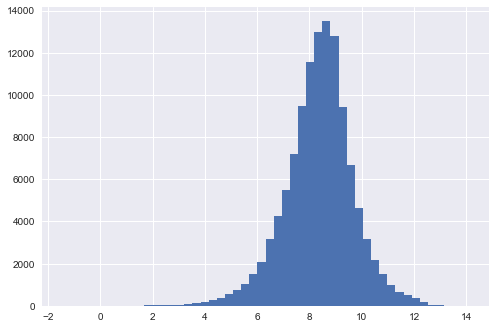

In [6]:
pd.Series(star_catalog.magnitudes).hist(bins=50)

The function *calc_md5* is used to calculate a MD5 checksum from the star catalog to detect changes of the file. In this case the features have to be recalculated.

In [7]:
from hashlib import md5

def calc_md5(file_name):
    fd = open(file_name)
    buffer = fd.read()
    hash = md5(buffer)
    fd.close()
    return hash.hexdigest()

In [8]:
signature = calc_md5('../data/hip_main.dat')

In [9]:
def distance(v):
    return np.sqrt(np.dot(v,v))

def get_key(mag1,mag2,normalized_angle,distance_ratio):
    key1 = '{:+d}'.format(int(np.rint(mag1*10.0)))
    key2 = '{:+d}'.format(int(np.rint(mag2*10.0)))
    key3 = '{:d}'.format(int(np.rint(normalized_angle * 10.0)))
    key4 = '{:d}'.format(int(np.rint(distance_ratio * 10.0)))
    return key3 + key4
    
def get_parameters(hips,relpos,relmag,distances):
    "Calculate the parameters for the nearest stars"
    param = list()
    if hips != None:
        param.extend(hips)
    param.extend(relmag)
    for index in range(len(distances)-1):
        d1 = distances[index]
        d2 = distances[index+1]
        v1 = relpos[index]
        v2 = relpos[index+1]
        cosalpha = np.dot(v1,v2)/(d1*d2)
        if np.abs(cosalpha) > 1.0:
            cosalpha = min(1.0, cosalpha)
            cosalpha = max(-1.0, cosalpha)
        normalized_angle = np.arccos(cosalpha)/np.pi
        param.append(normalized_angle)
        v = d2/d1 # value is always >= 1, because stars are ordered by their relative distance
        param.append(v)
        if index == 0:
            key = get_key(relmag[0],relmag[1],normalized_angle, v)
    param.append(key)
    return np.array(param)

def get_columns(n):
    "Get the columns names of all features"
    cols = []
    for i in range(n):
        cols.append('hip' + str(i+1))
    for i in range(n):
        cols.append('relative_magnitude' + str(i+1))
    if n > 1:
        for i in range(n-1):
            s = str(i+1) + str(i+2)
            cols.append('normalized_angle' + s)
            cols.append('relative_distance_ratio' + s)
    cols.append('key')
    return cols

def get_nearest_stars(ids, dist, n=1):
    "Get the n nearest stars"
    stars = []
    selection = np.array([True]*len(dist))
    while len(stars) < n:
        index = np.argmin(dist[selection])
        identifier = ids[selection][index]
        stars.append(identifier)
        selection[ids == identifier] = False
    return stars
    

In [10]:

# check first if the features have been already calculated
filename = '../data/hip_feat_' + str(signature) + '.csv'
if os.path.exists(filename):
    
    features = pd.read_csv(filename, index_col = 0)

else:

    # find the N closest stars to each star in the catalog
    N = 5
    ids = star_catalog.catalog['HIP'].values
    star_catalog.catalog.index = ids
    cat = zip(ids, star_catalog.star_vectors,star_catalog.magnitudes)
    features = pd.DataFrame(index = ids, 
                            columns = get_columns(N))

    for hip, pos, mag in cat:

        # get the nearest star
        selection = ids != hip
        dist = star_catalog.star_vectors[selection] - pos
        dist2 = np.sum(dist * dist, axis=1)
        nearest_stars = get_nearest_stars(ids[selection],dist2,n=N)
        
        hips = []
        relpos = []
        relmag = []
        distances = []
        for identifier in nearest_stars:
            index = np.where(ids[selection] == identifier)[0][0]
            hips.append(identifier)
            relpos.append(dist[index])
            relmag.append(star_catalog.magnitudes[selection][index] - mag)
            distances.append(np.sqrt(dist2[index]))

        # calculate star measures
        features.ix[hip] = get_parameters(hips, relpos, relmag, distances)


    features.to_csv(filename)

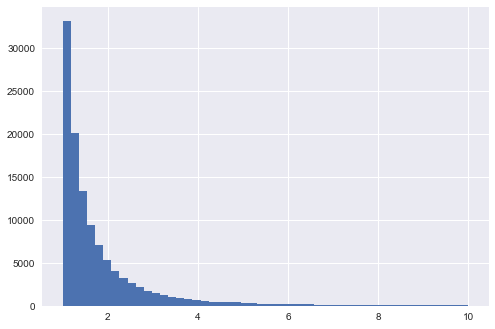

In [11]:
features['relative_distance_ratio12'][np.abs(features['relative_distance_ratio12']) < 10].hist(bins=50)

In [12]:
def get_data(filename, reshape=True):
    fd = open(filename,'r')
    lines = fd.readlines()
    fd.close()
    data = []
    for line in lines:
        arr = np.array(line.split(','),dtype = np.float)
        if reshape:
            arr = arr.reshape([len(arr) // 3, 3])
        data.append(arr)
    return data

There are the following cases in the star identification:

- the star can be a false star
- the star is a real star, but there are false stars in the neigbourhood

In [ ]:
def identify_stars(scene, features):
    "Identifies all stars in the scene including false stars"
    count,length = scene.shape
    selection = [True] * count
    stars = np.zeros(count)
    found = 0
    while found < 3 and not np.all(selection == False):
        # find the point in the scene, which is closest to the center
        m = np.mean(scene[selection,0:2],axis=1)
        x = scene[selection,0] - m[0]
        y = scene[selection,1] - m[1]
        dist2 = np.dot(x,x) + np.dot(y,y)
        index = np.argmin(dist2)
        selection[index] = False
        others = scene[selection,:] - scene[index,:]
        hip = classify_star(others, features)
        if hip > 0:
            stars[index] = hip
            found = found + 1
            
            
    return stars

def classify_star(others, features):
    "Searches the features array for a matching star"
    x = others[:,0]
    y = others[:,1]
    dist2 = x*x + y*y
    ids = np.arange(len(x))
    nearest_stars = get_nearest_stars(ids,dist2,n=5)
      
    relpos = []
    relmag = []
    distances = []
    for index in nearest_stars:
        relpos.append(others[index,0:2])
        relmag.append(others[index,2])
        distances.append(np.sqrt(dist2[index]))
        
    params = get_parameters(None,relpos,relmag,distances)
    key = params[-1]
    
    return 0

In [ ]:
# scenes = get_data('../data/input.csv')
scenes = get_data('../example/input_sample.csv')
results = get_data('../example/result_sample.csv', reshape=False)
for scene,result in zip(scenes,results):
    stars = identify_stars(scene, features)
    print stars
    print result